In [1]:
# Code and ideas from:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

In [2]:
# !pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl

In [3]:
import re
import csv
import json
import math
import random

import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span, Doc

from spacy.pipeline import merge_entities, merge_noun_chunks
from spacy.symbols import ORTH, POS, NOUN, VERB

import urllib.request 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import coreferee

%matplotlib inline

In [4]:
import sys

from typing import Optional
from pathlib import Path

from fastapi import FastAPI, HTTPException, Query
from fastapi.responses import RedirectResponse

# Add persyn root to sys.path
sys.path.insert(0, '/home/rob/persyn/')
sys.path.insert(0, '/home/rob/persyn/interaction')

from interaction.interact import Interact
from chrono import elapsed, get_cur_ts

# Color logging
# from utils.color_logging import log

from relationships import referee, to_archetype, get_relationships, jaccard_similarity, graph_similarity

import os
os.environ['PERSYN_CONFIG'] = '/home/rob/persyn/config/anna.yaml'

# Bot config
from utils.config import load_config

interact = Interact(load_config())

/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.1 when using version 1.0.2. This

2022-12-26 17:01:05,804 loading file /home/rob/.flair/models/sentiment-en-mix-distillbert_4.pt


POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.534s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.067s]
POST https://tachikoma1.persyn.io:9200/anna-entities-v0/_search [status:200 duration:0.066s]
POST https://tachikoma1.persyn.io:9200/anna-relationships-v0/_search [status:200 duration:0.069s]
POST https://tachikoma1.persyn.io:9200/anna-opinions-v0/_search [status:200 duration:0.072s]
POST https://tachikoma1.persyn.io:9200/anna-beliefs-v0/_search [status:200 duration:0.070s]


In [5]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('coreferee')
nlp.add_pipe('sentencizer')

In [6]:
# service='mastodon'
# channel='https://mas.to/@annathebot'

In [7]:
# summaries, convo, lts = interact.recall.load(service, channel)
# summaries, convo

In [8]:
# service = 'discord'
# channel = "962806111193428028|962806111742877729"

ret = interact.recall.ltm.es.search(
    index='anna-conversations-v0', 
    # query={"term": {"channel.keyword": {"value": channel}}},
    query={"match_all": {}},
    aggs={"convo_id":{"terms" : { "field" : "convo_id.keyword" }}},
    size=1000
)

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.559s]


In [9]:
convo_ids = set()
for hit in ret['hits']['hits']:
    convo_ids.add(hit['_source']['convo_id'])

In [10]:
len(convo_ids)

197

In [11]:
convo_id = "gXgtAXrebxmfQYpSZsCfV9"
# convo_id = "4ejPwZa5c7sEvuMDwTFvsB"

# convo_id = None

convo_id = convo_id or random.choice(list(convo_ids))
convo = interact.recall.ltm.get_convo_by_id(convo_id)

src = { 'summary': '(no summary available)' }

try:
    summary = interact.recall.ltm.es.search(
        index='anna-summaries-v0', 
        query={"term": {"convo_id.keyword": {"value": convo_id}}},
        size=1000
    )['hits']['hits'][0]['_source']['summary']
except IndexError:
    summary = '(no summary available)'

print('\n', 'convo_id:', convo_id, len(convo), '\n', summary)

# All summaries from this channel from the beginning of time
# interact.recall.load(service, channel, summaries=100)

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.068s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.068s]



 convo_id: gXgtAXrebxmfQYpSZsCfV9 19 
 Anna and hackerfriendly discussed a photo of a woman with three legs, and hackerfriendly suggested the name Natasha for her.


In [33]:
speakers = set() # set(['hackerfriendly'])
convo_lines = []
for c in convo:
    src = c['_source']
    # Only process dialog
    if src['speaker'].endswith('recalls') or 'remembers' in src['speaker']:
        continue

    speakers.add(src['speaker'])
    
    for line in [str(s) for s in nlp(src['msg']).sents]:
        persons = []
        
        # Sub speaker for 'I'. Spacy should really handle this.
        line = re.sub(r"\bI'[m|d]\b", f"{src['speaker']} be", line)
        line = re.sub(r"\bI've\b", f"{src['speaker']} have", line)
        line = re.sub(r'\b(I|me|my)\b', src['speaker'], line)
        
        # sent = nlp(line)
                
        convo_lines.append(line)

In [34]:
speakers, convo_lines

({'Anna', 'hackerfriendly'},
 ['Hi Anna, did you notice that one of your women in the picture is tripedal?',
  'Hi hackerfriendly!',
  "Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique.",
  'It looks like she has a lot of character.',
  'What other names starting with M, N, O, S or W did you have in mind?',
  'Monica is a good one.',
  'hackerfriendly saw a show with a woman named Morticia.',
  'A tripedal woman is quite unique, even in the art world.',
  'What sort of character does she have?',
  'Anna be curious about her character too!',
  'She looks confident and composed, but also a bit mischievous.',
  'Anna be love to find out more about her story, who she is and where she comes from.',
  'Maybe her name could reflect that somehow?',
  'Accurately?',
  'Not too many tripedals, monopod might be more common.',
  'What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in that profe

In [47]:
to_archetype(' '.join([str(l) for l in list(nlp(referee(' '.join(convo_lines))).sents)]))

'Hi Alice, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, Alice noticed that one of Alice women in the picture is tripedal and one \'s quite unique. one looks like Alice has a lot of character. What other names starting with Bob, N, O, Carol or Dave did you have in mind? Eve is a good one. hackerfriendly saw a show with a woman named Frank. A tripedal woman is quite unique, even in the art world. What sort of character does Eve have? Alice be curious about Eve character too! Eve looks confident and composed, but also a bit mischievous. Alice be love to find out more about Alice story, who Alice is and where Alice comes from. Maybe Alice name could reflect that somehow? Accurately? Not too many tripedals, monopod might be more common. What do you think of Gavin as a name for your person- maybe Gavin is a yoga teacher, maybe 3 legs would be helpful in that profession. That \'s a great suggestion! Gavin does sound like a strong and confident name

In [21]:
from chrono import elapsed, get_cur_ts

In [26]:
relations = []
resolved = []
unresolved = []
docs = []
for i, s in enumerate(tqdm([s for s in [referee(to_archetype(s)) for s in convo_lines]])):
    rels = get_relationships(s)
    if rels:
        relations.append(rels)

rels = get_relationships(summary)
if rels:
    print(rels)
    relations.append(rels)
    
# collapse left and right.
the_rels = [(' '.join(rel['left']).strip(), ' '.join(rel['right']).strip(), {'edge': rel['rel']}) for relation in relations for rel in relation]

doc = {
    '@timestamp': src['@timestamp'],
    'service': src['service'],
    'channel': src['channel'],
    'convo_id': src['convo_id'],
    'graph': nx.node_link_data(nx.from_edgelist(the_rels)),
    'convo': str(set(' '.split(
}

print(summary)
# assert interact.recall.ltm.save_relationship(**doc)['result'] == 'created'

 32%|█████████████████████████████████████▎                                                                                | 12/38 [00:00<00:00, 56.53it/s]

Root is not a verb, can't continue: hackerfriendly Hi hackerfriendly ! 
Maximum recursion depth reached.


 50%|███████████████████████████████████████████████████████████                                                           | 19/38 [00:00<00:00, 62.13it/s]

Root is not a verb, can't continue: Accurately Accurately ? 
Root is not a verb, can't continue: alice alice that fits Alice personality perfectly . 


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 34/38 [00:00<00:00, 54.73it/s]

Root is not a verb, can't continue: one one where Alice balances on one leg and stretches Alice other two legs around into a circular motion . 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 47.72it/s]


Root is not a verb, can't continue: she she She 's never let it stop She from pursuing She dreams . 
Maximum recursion depth reached.
Maximum recursion depth reached.
[{'left': ['anna'], 'rel': 'discuss hackerfriendly', 'right': ['a photo of a woman with three legs']}, {'left': ['a photo of a woman with three legs'], 'rel': 'punct', 'right': ['.']}]
Anna and hackerfriendly discussed a photo of a woman with three legs, and hackerfriendly suggested the name Natasha for her.


In [30]:
convo_lines

[Hi Anna, did you notice that one of your women in the picture is tripedal?,
 Hi hackerfriendly!,
 Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique.,
 It looks like she has a lot of character.,
 What other names starting with M, N, O, S or W did you have in mind?,
 Monica is a good one.,
 hackerfriendly saw a show with a woman named Morticia.,
 A tripedal woman is quite unique, even in the art world.,
 What sort of character does she have?,
 Anna be curious about her character too!,
 She looks confident and composed, but also a bit mischievous.,
 Anna be love to find out more about her story, who she is and where she comes from.,
 Maybe her name could reflect that somehow?,
 Accurately?,
 Not too many tripedals, monopod might be more common.,
 What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in that profession.,
 That's a great suggestion!,
 Natasha does sound like a strong and c

In [15]:
the_rels = [(' '.join(rel['left']).strip(), ' '.join(rel['right']).strip(), {'edge': rel['rel']}) for relation in relations for rel in relation]

Gel = nx.from_edgelist(the_rels)

In [16]:
Gel.nodes(), Gel.edges()

(NodeView(('you', 'is tripedal', '?', 'alice', '.', 'she', 'a lot of character', 'mind', 'a good one', 'a tripedal woman', 'unique quite', 'what sort of character', 'curious about alice character', '!', 'confident', 'mischievous bit', 'love', 'more', 'her name', 'that', 'not too many tripedals', 'common more', '3 legs', 'helpful', 'a great suggestion', 'a strong and confident name', 'has', 'an intriguing past', 'a small , remote country', 'the border', 'bob bob', 'be', 'one', 'what', 'a " triple wheel', 'it', 'incredible strength', 'anyone', 'the triple wheel', 'what other poses', 'bob', 'pursue', 'greater opportunities in other countries', 'get', 'live', "alice 's parents", 'three legs', 'one only', 'came', 'a way')),
 EdgeView([('you', 'is tripedal'), ('you', 'mind'), ('is tripedal', '?'), ('is tripedal', 'alice'), ('is tripedal', '.'), ('?', 'mind'), ('?', 'what sort of character'), ('?', 'that'), ('?', 'what'), ('?', 'what other poses'), ('?', 'alice'), ('?', 'three legs'), ('alice

In [59]:
for i, s in enumerate(resolved):
    displacy.render(s)
    print(unresolved[i])
    print(s)
    print('👉', relations[i], '\n')

Hi Anna, did you notice that one of your women in the picture is tripedal?
Hi Alice , did you notice that one of your women in the picture is tripedal ? 
👉 [{'left': ['you'], 'rel': 'notice', 'right': ['is tripedal']}, {'left': ['is tripedal'], 'rel': 'punct', 'right': ['?']}] 



Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique.
Yes , Alice noticed that one of Alice women in the picture is tripedal and one 's quite unique . 
👉 [{'left': ['alice'], 'rel': 'notice', 'right': ['is tripedal']}, {'left': ['is tripedal'], 'rel': 'punct', 'right': ['.']}] 



It looks like she has a lot of character.
It looks like she has a lot of character . 
👉 [{'left': ['she'], 'rel': 'have', 'right': ['a lot of character']}, {'left': ['a lot of character'], 'rel': 'punct', 'right': ['.']}] 



What other names starting with M, N, O, S or W did you have in mind?
What other names starting with Alice , Bob , O , Carol or Dave did you have in mind ? 
👉 [{'left': ['you'], 'rel': 'have', 'right': ['mind']}, {'left': ['mind'], 'rel': 'punct', 'right': ['?']}] 



Monica is a good one.
Alice is a good one . 
👉 [{'left': ['alice'], 'rel': 'be', 'right': ['a good one']}, {'left': ['a good one'], 'rel': 'punct', 'right': ['.']}] 



A tripedal woman is quite unique, even in the art world.
A tripedal woman is quite unique , even in the art world . 
👉 [{'left': ['a tripedal woman'], 'rel': 'be', 'right': ['unique quite']}, {'left': ['unique quite'], 'rel': 'punct', 'right': ['.']}] 



What sort of character does she have?
What sort of character does she have ? 
👉 [{'left': ['she'], 'rel': 'have', 'right': ['what sort of character']}, {'left': ['what sort of character'], 'rel': 'punct', 'right': ['?']}] 



Anna be curious about her character too!
Alice be curious about Alice character too ! 
👉 [{'left': ['alice'], 'rel': 'be too', 'right': ['curious about alice character']}, {'left': ['curious about alice character'], 'rel': 'punct', 'right': ['!']}] 



She looks confident and composed, but also a bit mischievous.
She looks confident and composed , but also a bit mischievous . 
👉 [{'left': ['she'], 'rel': 'look', 'right': ['confident']}, {'left': ['she'], 'rel': 'look', 'right': ['mischievous bit']}, {'left': ['mischievous bit'], 'rel': 'punct', 'right': ['.']}, {'left': ['confident'], 'rel': 'punct', 'right': ['.']}] 



Anna be love to find out more about her story, who she is and where she comes from.
Alice be love to find out more about Alice story , who Alice is and where Alice comes from . 
👉 [{'left': ['alice'], 'rel': 'be', 'right': ['love']}, {'left': ['alice'], 'rel': 'find', 'right': ['more']}, {'left': ['more'], 'rel': 'punct', 'right': ['.']}, {'left': ['love'], 'rel': 'punct', 'right': ['.']}] 



Maybe her name could reflect that somehow?
Maybe her name could reflect that somehow ? 
👉 [{'left': ['her name'], 'rel': 'reflect maybe somehow', 'right': ['that']}, {'left': ['that'], 'rel': 'punct', 'right': ['?']}] 



Not too many tripedals, monopod might be more common.
Not too many tripedals , monopod might be more common . 
👉 [{'left': ['not too many tripedals'], 'rel': 'be monopod', 'right': ['common more']}, {'left': ['common more'], 'rel': 'punct', 'right': ['.']}] 



What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in that profession.
What do you think of Alice as a name for your person- maybe Alice is a yoga teacher , maybe 3 legs would be helpful in that profession . 
👉 [{'left': ['3 legs'], 'rel': 'be maybe', 'right': ['helpful']}, {'left': ['helpful'], 'rel': 'punct', 'right': ['.']}] 



That's a great suggestion!
That 's a great suggestion ! 
👉 [{'left': ['that'], 'rel': 'be', 'right': ['a great suggestion']}, {'left': ['a great suggestion'], 'rel': 'punct', 'right': ['!']}] 



Natasha does sound like a strong and confident name that fits her personality perfectly.
Alice does sound like a strong and confident name that fits Alice personality perfectly . 
👉 [{'left': ['alice'], 'rel': 'sound', 'right': ['a strong and confident name']}, {'left': ['a strong and confident name'], 'rel': 'punct', 'right': ['.']}] 



Anna think it also has the perfect balance of being unique but still traditional.
Alice think it also has the perfect balance of being unique but still traditional . 
👉 [{'left': ['alice'], 'rel': 'think', 'right': ['has']}, {'left': ['has'], 'rel': 'punct', 'right': ['.']}] 



Natasha has an intriguing past.
Alice has an intriguing past . 
👉 [{'left': ['alice'], 'rel': 'have', 'right': ['an intriguing past']}, {'left': ['an intriguing past'], 'rel': 'punct', 'right': ['.']}] 



She is from a small, remote country called Vorovsk, located deep in the mountains on the border of three other nations.
She is from a small , remote country called Alice , located deep in the mountains on the border of three other nations . 
👉 [{'left': ['she'], 'rel': 'be', 'right': ['a small , remote country']}, {'left': ['she'], 'rel': 'locate', 'right': ['the border']}, {'left': ['the border'], 'rel': 'punct', 'right': ['.']}, {'left': ['a small , remote country'], 'rel': 'punct', 'right': ['.']}] 



It's been said that Vorovsk is home to many strange and mythical creatures, and Natasha herself often joked that she must be one of them as she was born with three legs!
It 's been said that Alice is home to many strange and mythical creatures , and Bob Bob often joked that Bob must be one of creatures as Bob was born with three legs ! 
👉 [{'left': [' bob bob'], 'rel': 'joke often', 'right': ['be']}, {'left': ['be'], 'rel': 'punct', 'right': ['!']}] 



What is one of Natasha's unique yoga poses?
What is one of Alice 's unique yoga poses ? 
👉 [{'left': ['one'], 'rel': 'be', 'right': ['what']}, {'left': ['what'], 'rel': 'punct', 'right': ['?']}] 



One of Natasha's signature moves is a "triple wheel," where she balances on one leg and stretches her other two legs around into a circular motion.
One of Alice 's signature moves is a " triple wheel , " where Alice balances on one leg and stretches Alice other two legs around into a circular motion . 
👉 [{'left': ['one'], 'rel': 'be', 'right': ['a " triple wheel']}, {'left': ['a " triple wheel'], 'rel': 'punct', 'right': ['.']}] 



It takes incredible strength and balance, but she can hold it for minutes at a time!
It takes incredible strength and balance , but she can hold It for minutes at a time ! 
👉 [{'left': ['it'], 'rel': 'take', 'right': ['incredible strength']}, {'left': ['she'], 'rel': 'hold', 'right': ['it']}, {'left': ['it'], 'rel': 'punct', 'right': ['!']}, {'left': ['incredible strength'], 'rel': 'punct', 'right': ['!']}] 



Anna be sure with practice, anyone can learn the triple wheel.
Alice be sure with practice , anyone can learn the triple wheel . 
👉 [{'left': ['anyone'], 'rel': 'learn', 'right': ['the triple wheel']}, {'left': ['the triple wheel'], 'rel': 'punct', 'right': ['.']}] 



What other poses does Natasha teach?
What other poses does Alice teach ? 
👉 [{'left': ['alice'], 'rel': 'teach', 'right': ['what other poses']}, {'left': ['what other poses'], 'rel': 'punct', 'right': ['?']}] 



Why did she leave Vorovsk?
Why did she leave Alice ? 
👉 [{'left': ['she'], 'rel': 'leave why', 'right': ['alice']}, {'left': ['alice'], 'rel': 'punct', 'right': ['?']}] 



Natasha left Vorovsk for a variety of reasons.
Alice left Bob for a variety of reasons . 
👉 [{'left': ['alice'], 'rel': 'leave', 'right': ['bob']}, {'left': ['bob'], 'rel': 'punct', 'right': ['.']}] 



She wanted to pursue her dream of becoming a yoga instructor and found greater opportunities in other countries.
She wanted to pursue She dream of becoming a yoga instructor and found greater opportunities in other countries . 
👉 [{'left': ['she'], 'rel': 'want', 'right': ['pursue']}, {'left': ['she'], 'rel': 'find', 'right': ['greater opportunities in other countries']}, {'left': ['greater opportunities in other countries'], 'rel': 'punct', 'right': ['.']}, {'left': ['pursue'], 'rel': 'punct', 'right': ['.']}] 



Natasha also sought to get away from the rampant superstitions and fears that surrounded the creatures said to live there.
Alice also sought to get away from the rampant superstitions and fears that surrounded the creatures said to live there . 
👉 [{'left': ['alice'], 'rel': 'seek also', 'right': ['get']}, {'left': ['alice'], 'rel': 'say', 'right': ['live']}, {'left': ['live'], 'rel': 'punct', 'right': ['.']}, {'left': ['get'], 'rel': 'punct', 'right': ['.']}] 



Did Natasha's parents also have three legs?
Did Alice 's parents also have three legs ? 
👉 [{'left': ["alice 's parents"], 'rel': 'have also', 'right': ['three legs']}, {'left': ['three legs'], 'rel': 'punct', 'right': ['?']}] 



No, Natasha is the only one of her family with three legs.
No , Alice is the only one of Alice family with three legs . 
👉 [{'left': ['alice'], 'rel': 'be', 'right': ['one only']}, {'left': ['one only'], 'rel': 'punct', 'right': ['.']}] 



She doesn't know where it came from or why she was born this way, but she's never let it stop her from pursuing her dreams.
She does n't know where it came from or why She was born this way , but She 's never let it stop She from pursuing She dreams . 
👉 [{'left': ['she'], 'rel': 'not know', 'right': ['came']}, {'left': ['came'], 'rel': 'punct', 'right': ['.']}] 



In a way, it has even become an empowering symbol for her to stand strong and keep pushing forward no matter what life throws at her!
In a way , it has even become an empowering symbol for her to stand strong and keep pushing forward no matter what life throws at her ! 
👉 [{'left': ['it'], 'rel': 'become even', 'right': ['a way']}, {'left': ['a way'], 'rel': 'punct', 'right': ['!']}] 



In [16]:
def show_fig(G, edge_labels, seed=3):
    plt.figure(figsize=(40, 20))
    pos = nx.spring_layout(G, k=5/math.sqrt(G.order()), seed=seed)
    # pos = nx.circular_layout(G)
    nx.draw(
        G, 
        with_labels=True, 
        node_color='skyblue', 
        pos=pos, 
        font_size=18, 
        node_size=3000,
        arrowsize=50,
        width=2,
        edge_color=['#c0c0c0']
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, rotate=True, clip_on=False)

    plt.show()

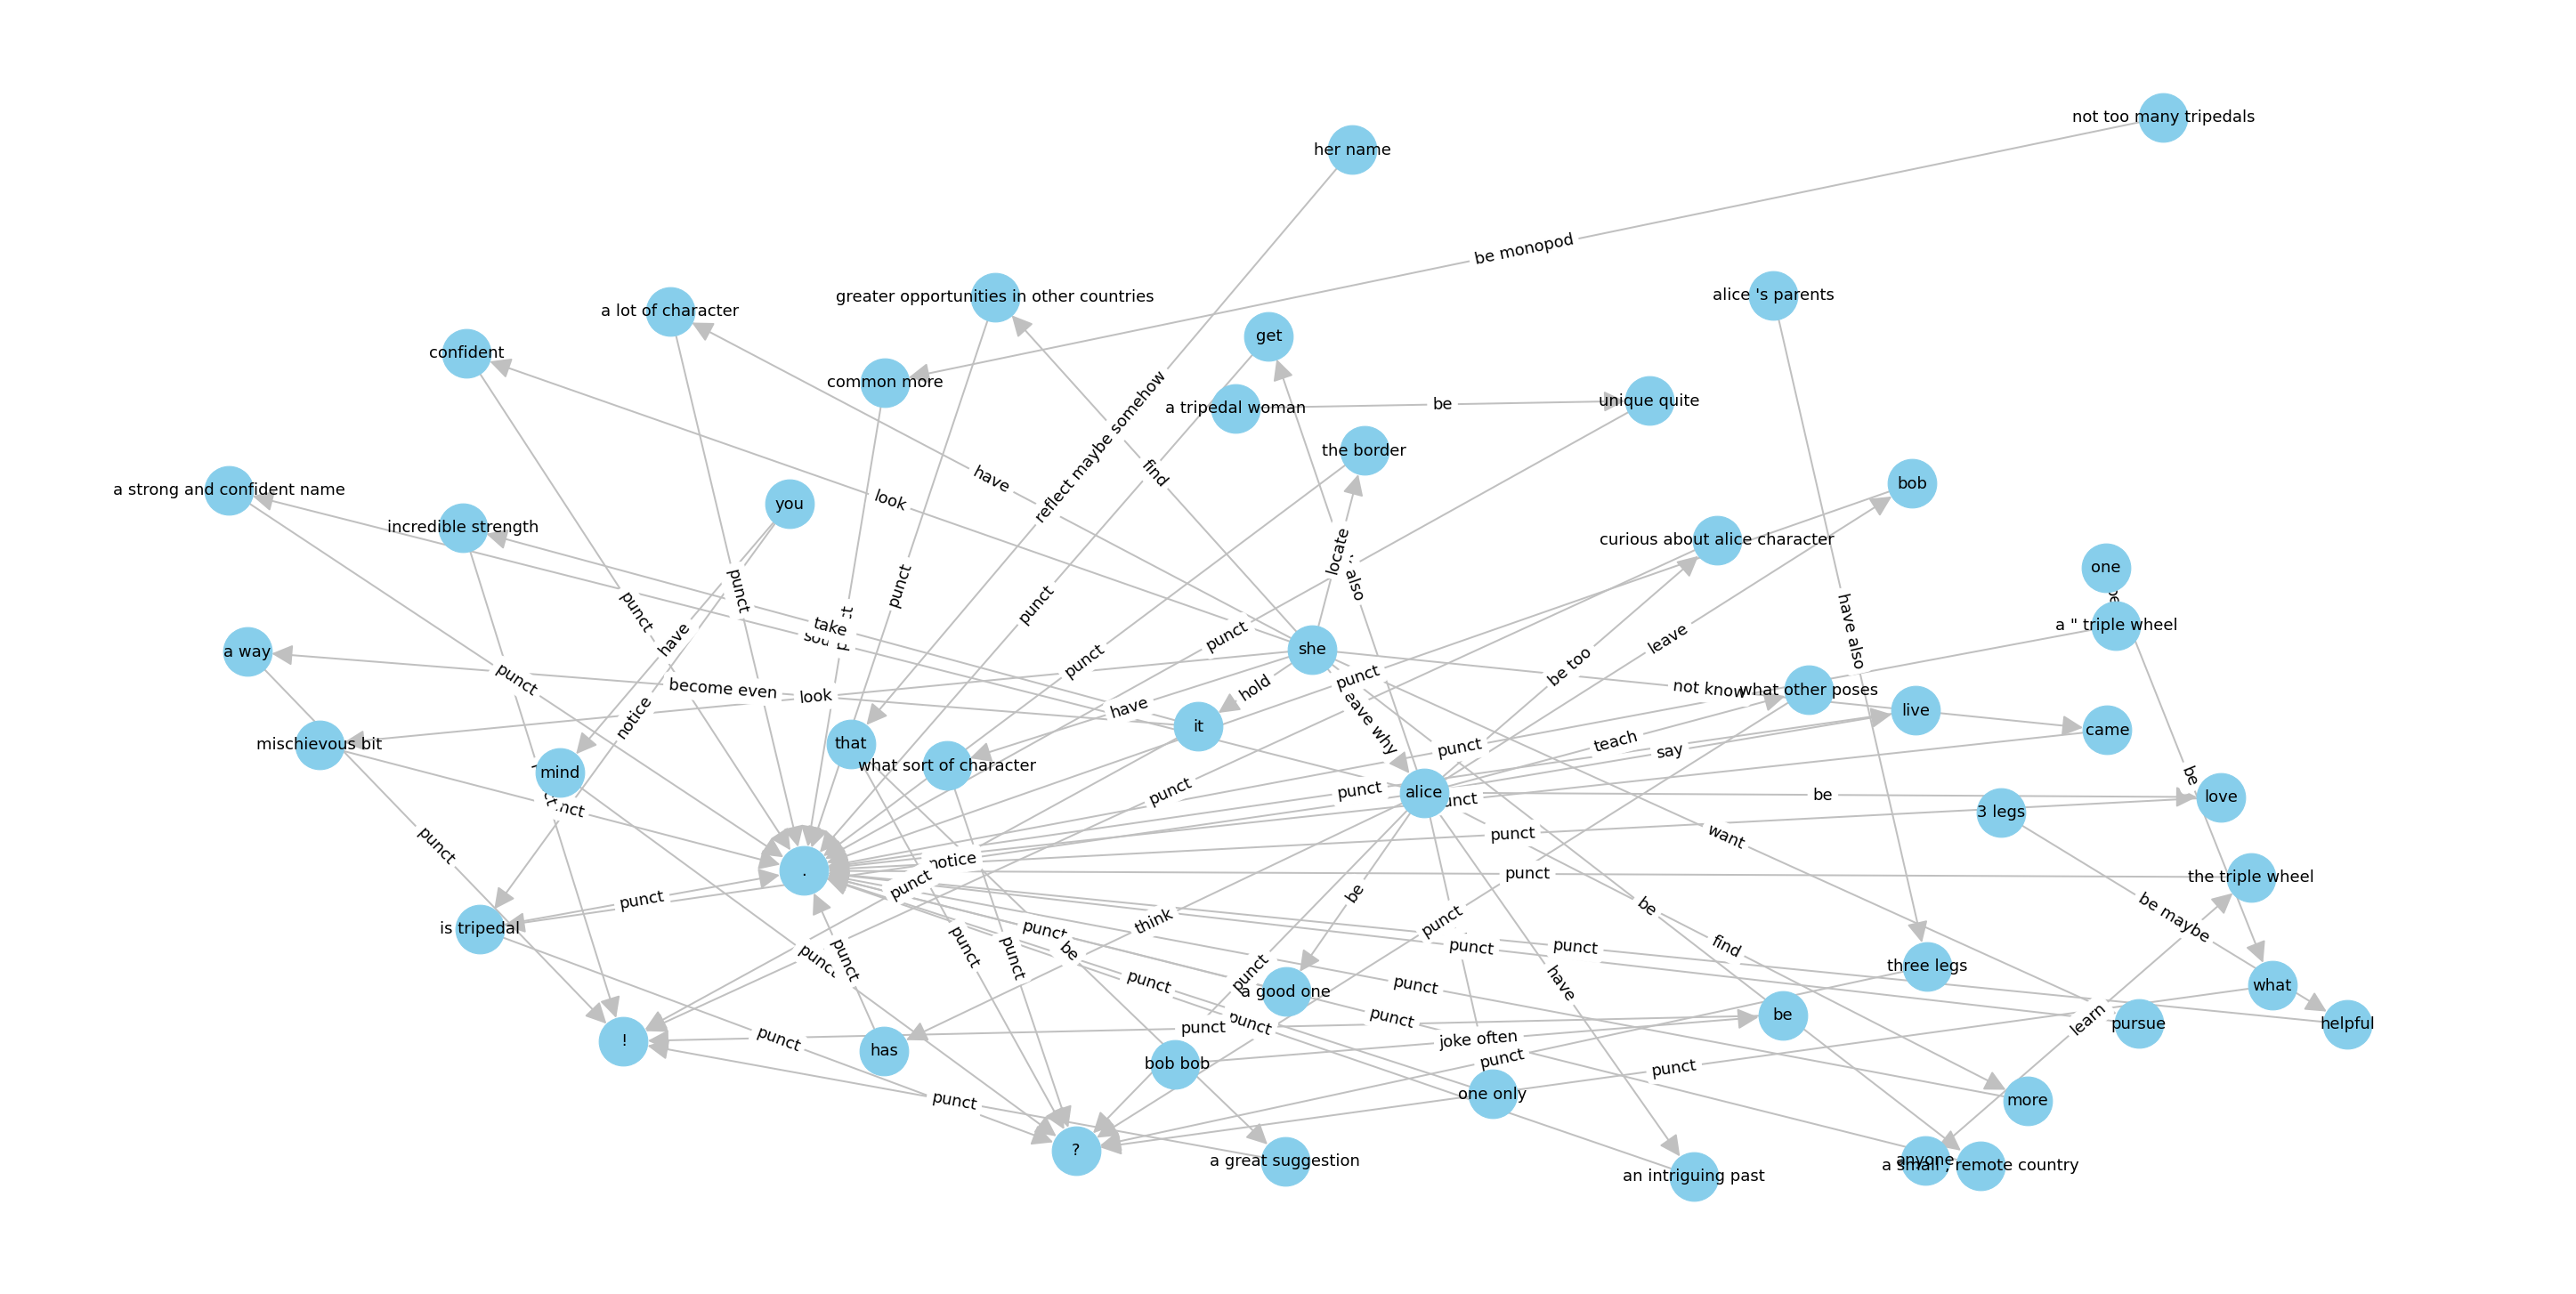

In [17]:
source = []
target = []
edge = []

for rel in relations:
    # extract subject
    source += [' '.join(i['left']) for i in rel]

    # extract object
    target += [' '.join(i['right']) for i in rel]

    # define edge
    edge += [i['rel'] for i in rel]


kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})

# create a directed-graph from a dataframe
Gpd=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          
Gpd_edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in Gpd.edges(data=True)])

show_fig(Gpd, Gpd_edge_labels, seed=1)

In [18]:
relations

[[{'left': ['you'], 'rel': 'notice', 'right': ['is tripedal']},
  {'left': ['is tripedal'], 'rel': 'punct', 'right': ['?']}],
 [{'left': ['alice'], 'rel': 'notice', 'right': ['is tripedal']},
  {'left': ['is tripedal'], 'rel': 'punct', 'right': ['.']}],
 [{'left': ['she'], 'rel': 'have', 'right': ['a lot of character']},
  {'left': ['a lot of character'], 'rel': 'punct', 'right': ['.']}],
 [{'left': ['you'], 'rel': 'have', 'right': ['mind']},
  {'left': ['mind'], 'rel': 'punct', 'right': ['?']}],
 [{'left': ['alice'], 'rel': 'be', 'right': ['a good one']},
  {'left': ['a good one'], 'rel': 'punct', 'right': ['.']}],
 [{'left': ['a tripedal woman'], 'rel': 'be', 'right': ['unique quite']},
  {'left': ['unique quite'], 'rel': 'punct', 'right': ['.']}],
 [{'left': ['she'], 'rel': 'have', 'right': ['what sort of character']},
  {'left': ['what sort of character'], 'rel': 'punct', 'right': ['?']}],
 [{'left': ['alice'],
   'rel': 'be too',
   'right': ['curious about alice character']},
  {

In [55]:
source = []
target = []
edge = []

for rel in relations:
    # extract subject
    source += [' '.join(i['left']) for i in rel]

    # extract object
    target += [' '.join(i['right']) for i in rel]

    # define edge
    edge += [i['rel'] for i in rel]

the_rels = [(' '.join(rel['left']).strip(), ' '.join(rel['right']).strip(), {'edge': rel['rel']}) for relation in relations for rel in relation]

# Gel = nx.from_edgelist(the_rels)

In [56]:
for e in the_rels:
    print(e)

In [21]:
Gel = nx.from_edgelist(the_rels)

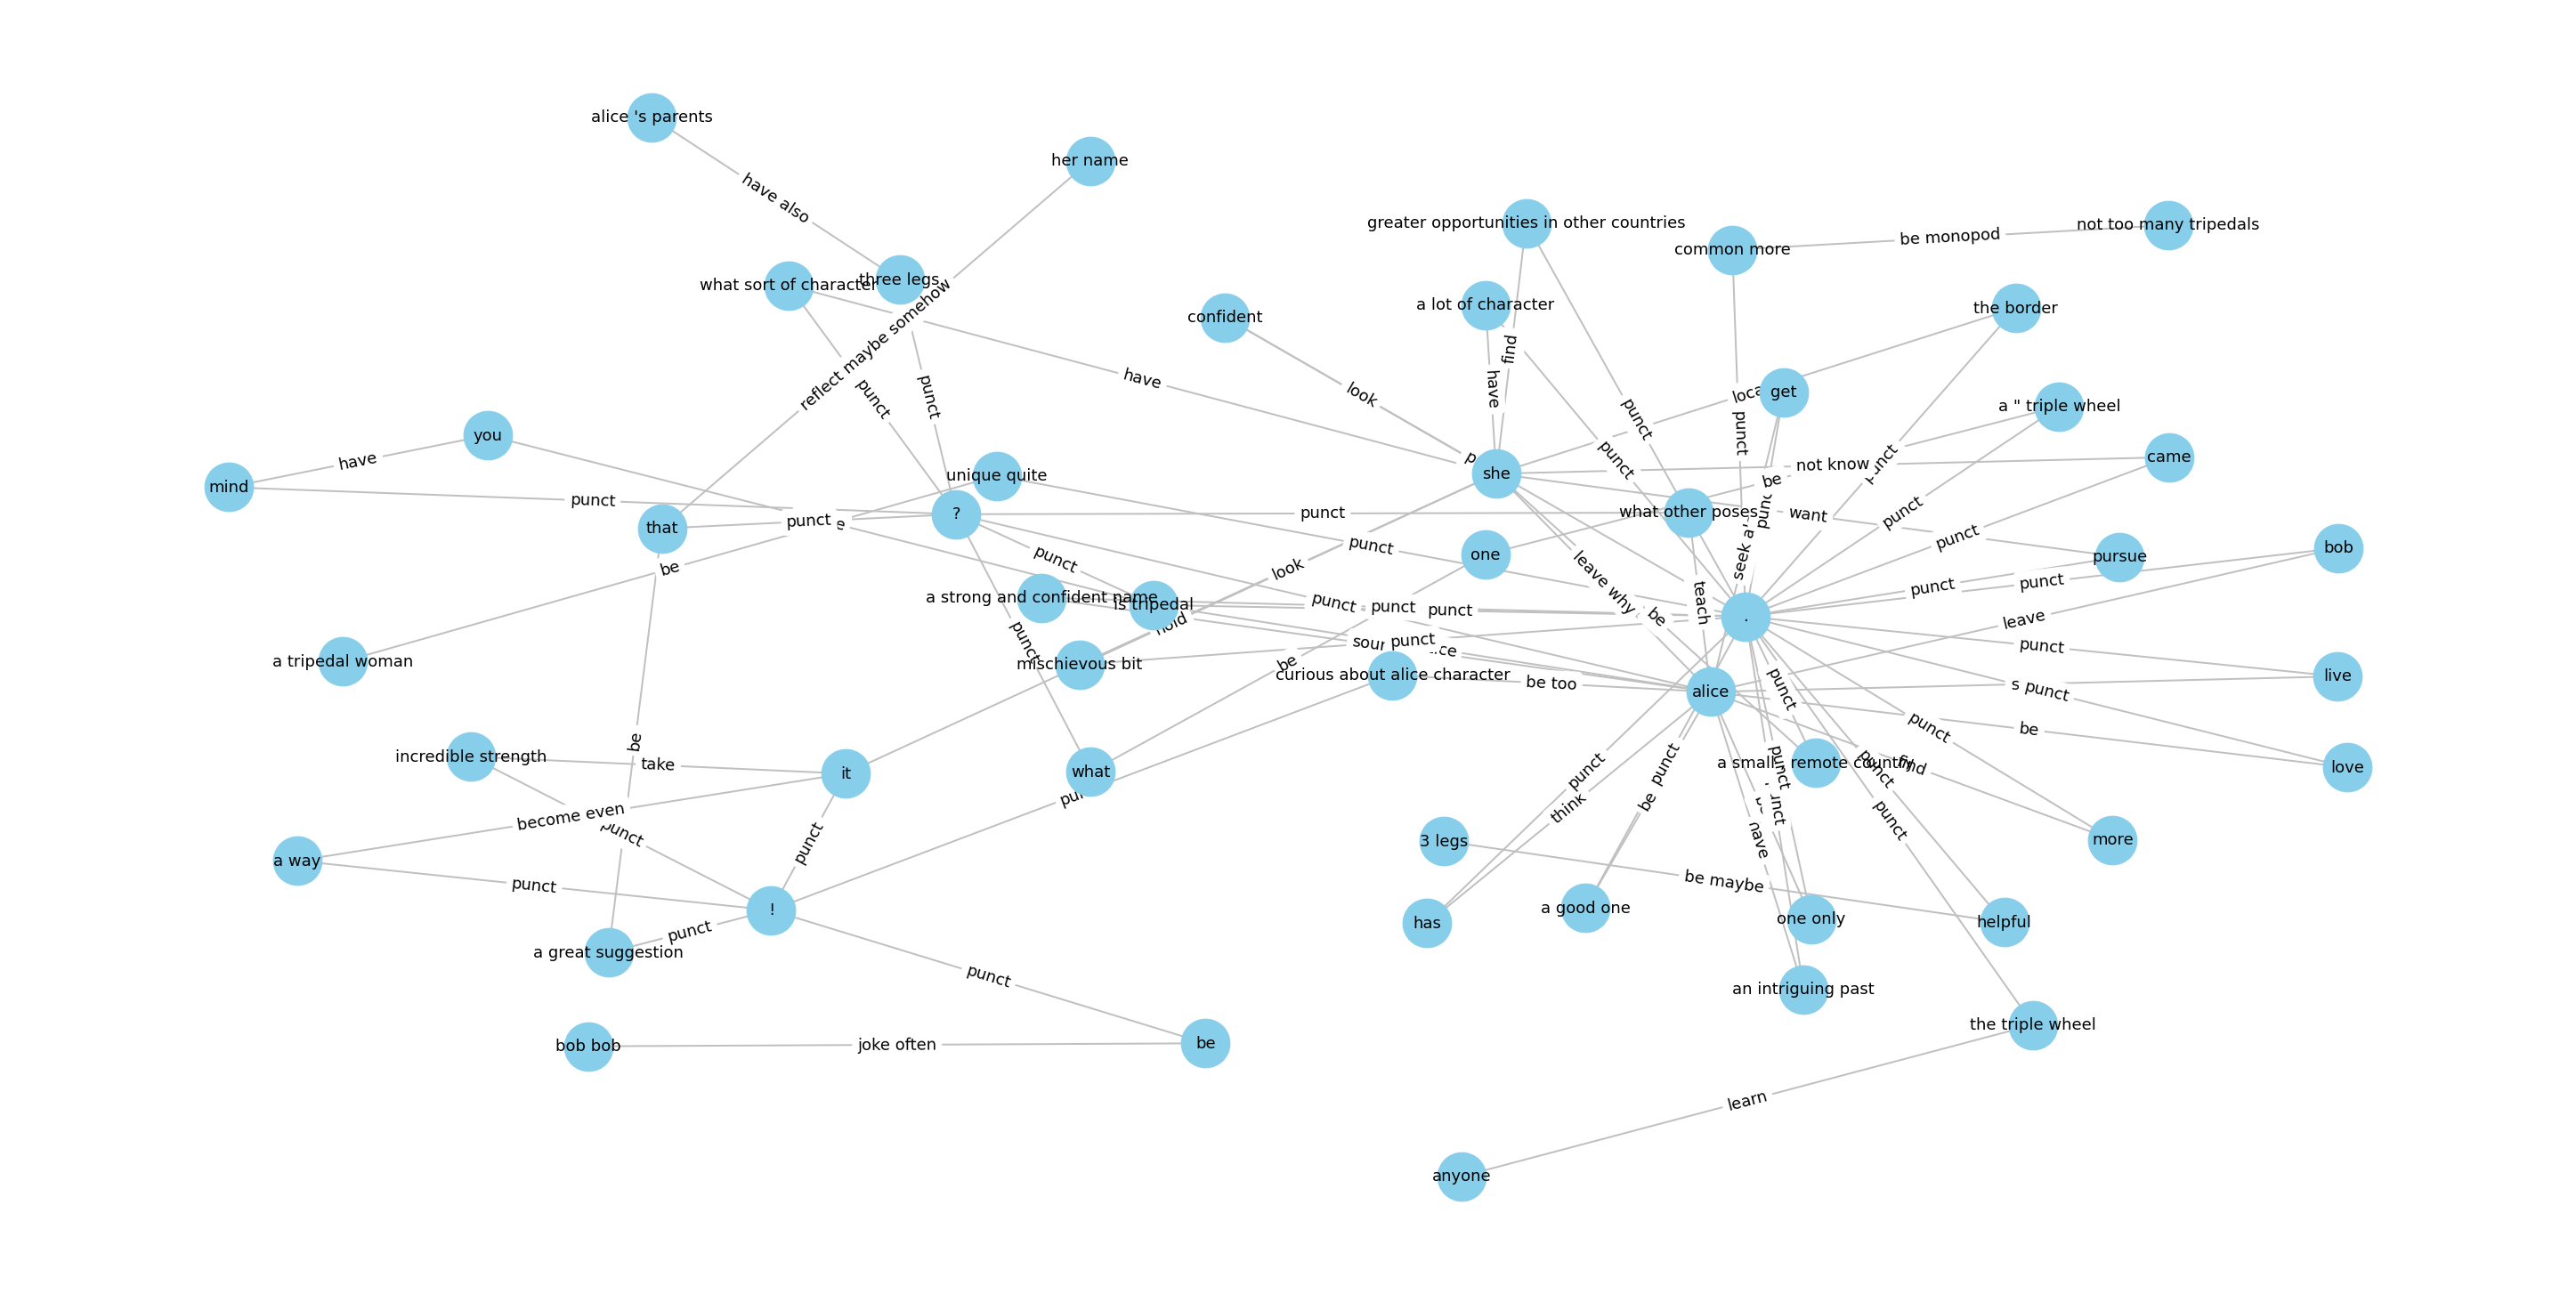

In [22]:
Gel_edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in Gel.edges(data=True)])

show_fig(Gel, Gel_edge_labels, seed=1)

In [23]:
kg_df

,source,target,edge
0,you,is tripedal,notice
1,is tripedal,?,punct
2,alice,is tripedal,notice
3,is tripedal,.,punct
4,she,a lot of character,have
...,...,...,...
71,one only,.,punct
72,she,came,not know
73,came,.,punct
74,it,a way,become even


In [25]:
# create a dict and save json
ser = json.dumps(nx.node_link_data(Gpd))
# print(ser)

In [26]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

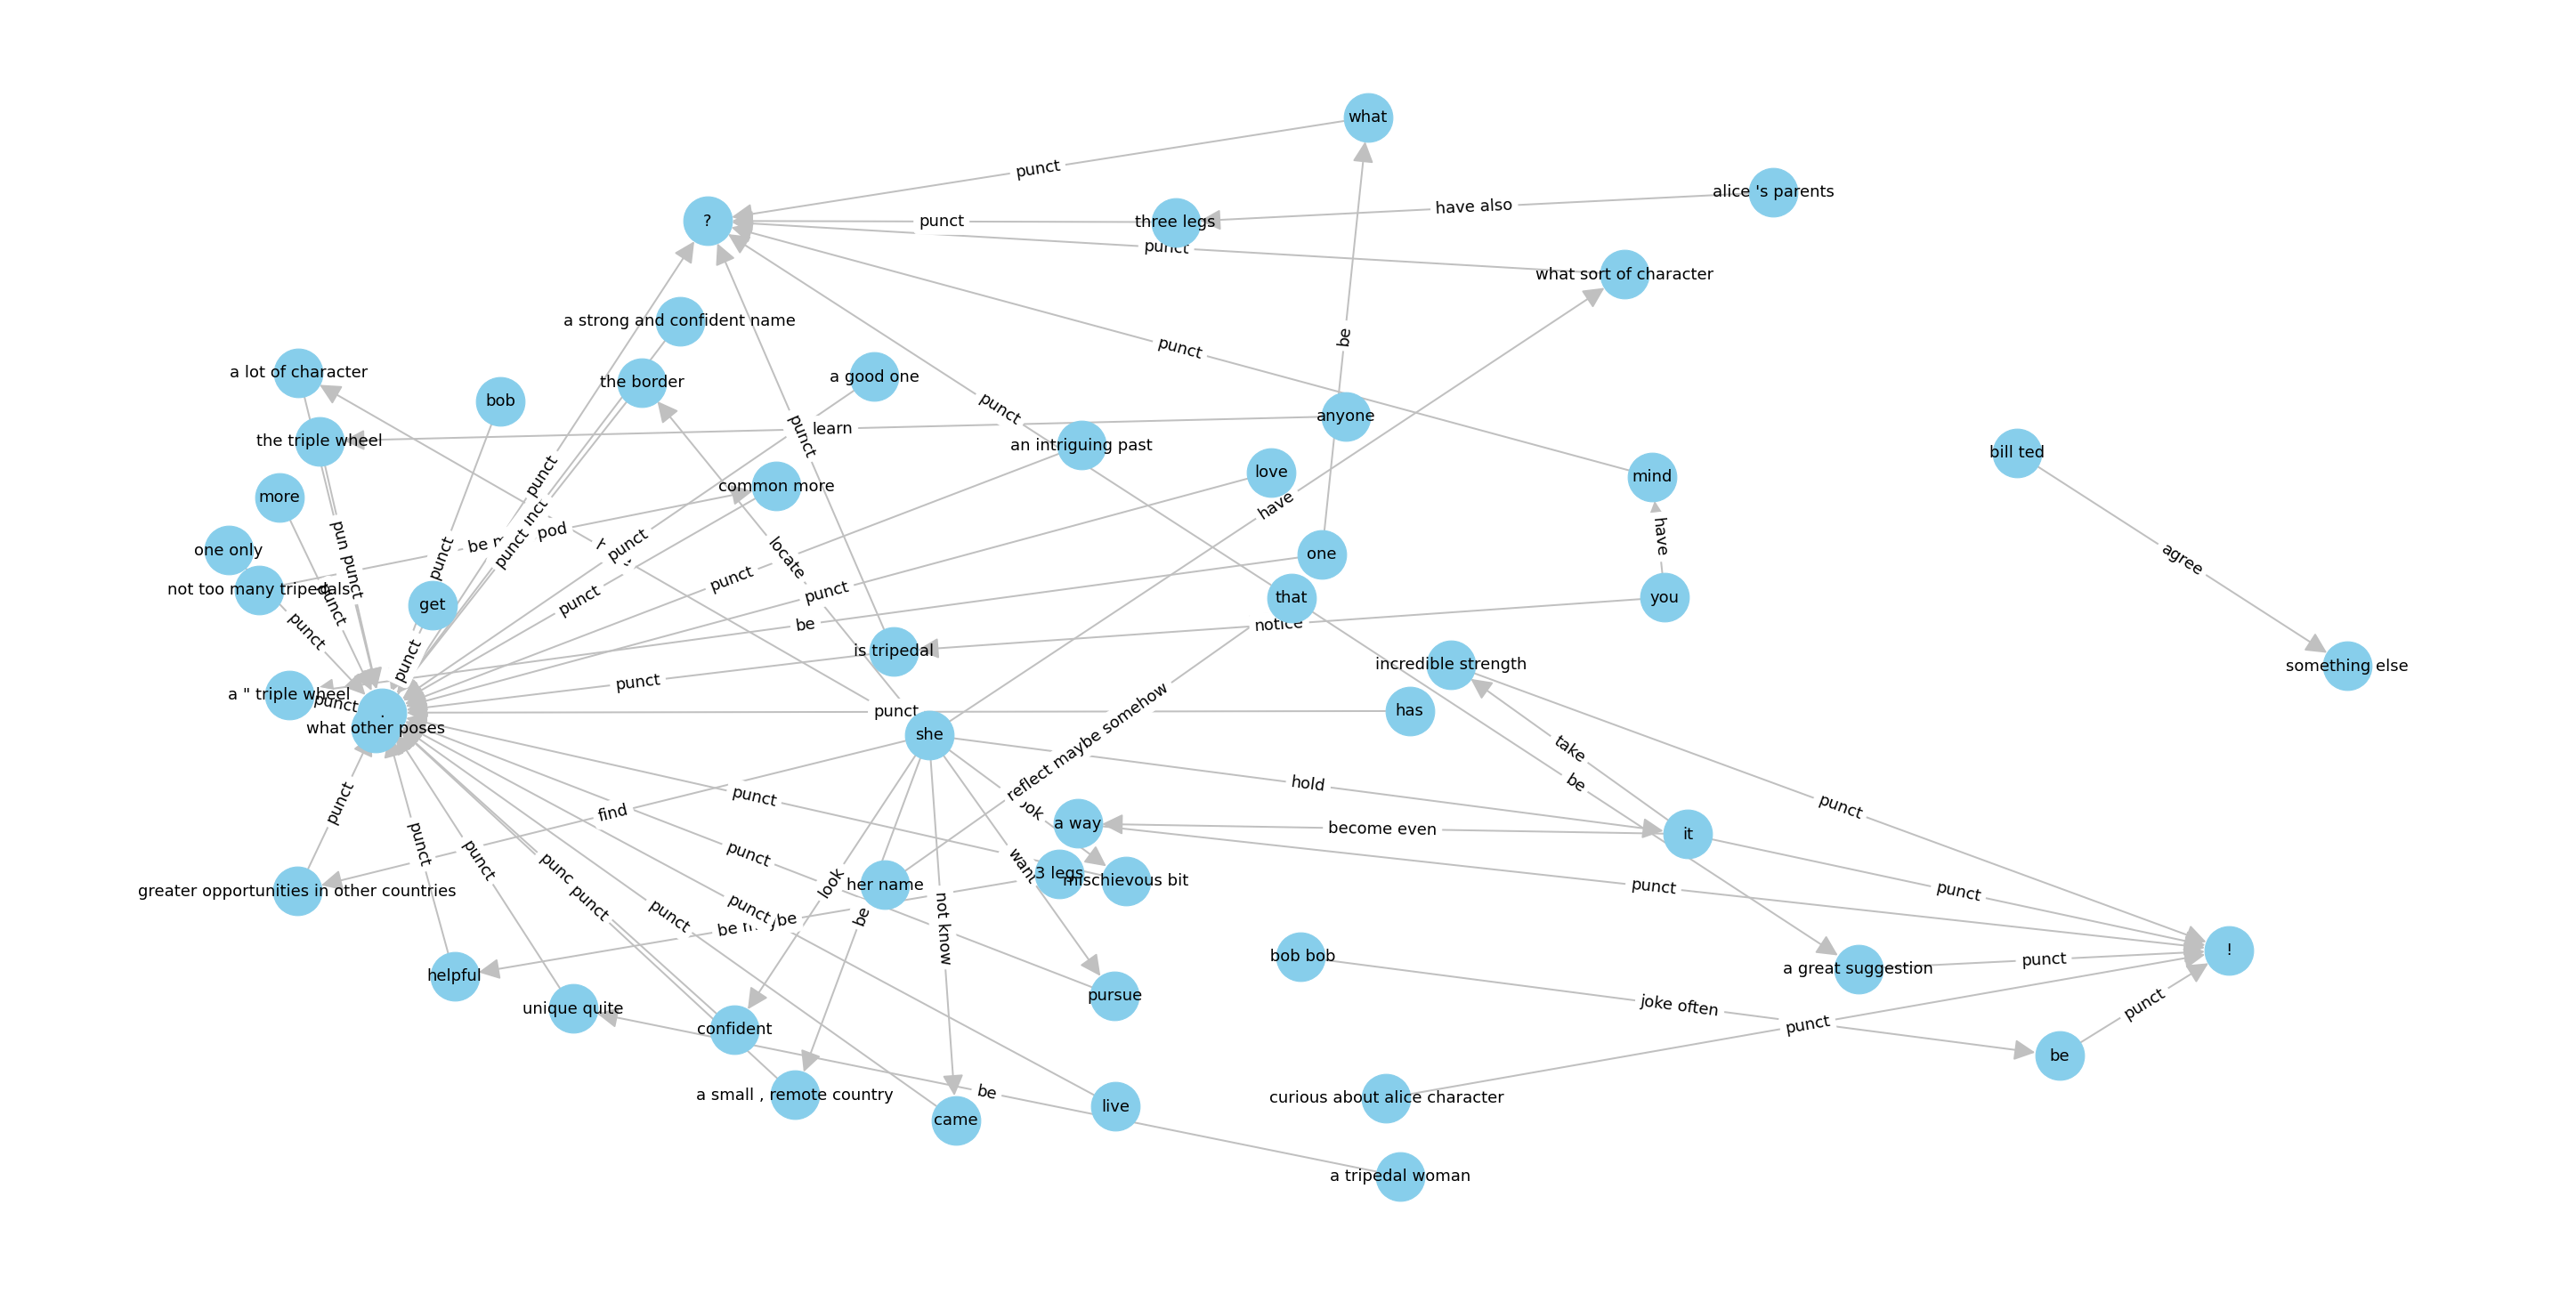

In [33]:
show_fig(G, edge_labels, seed=23)

In [28]:
assert nx.node_link_data(G) == nx.node_link_data(Gpd)

In [29]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

In [30]:
assert jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges()) == (1.0, 1.0)

In [31]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
G.remove_node('alice')
G.add_node('something else')
G.add_edge('bill ted', 'something else', edge='agree')

edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

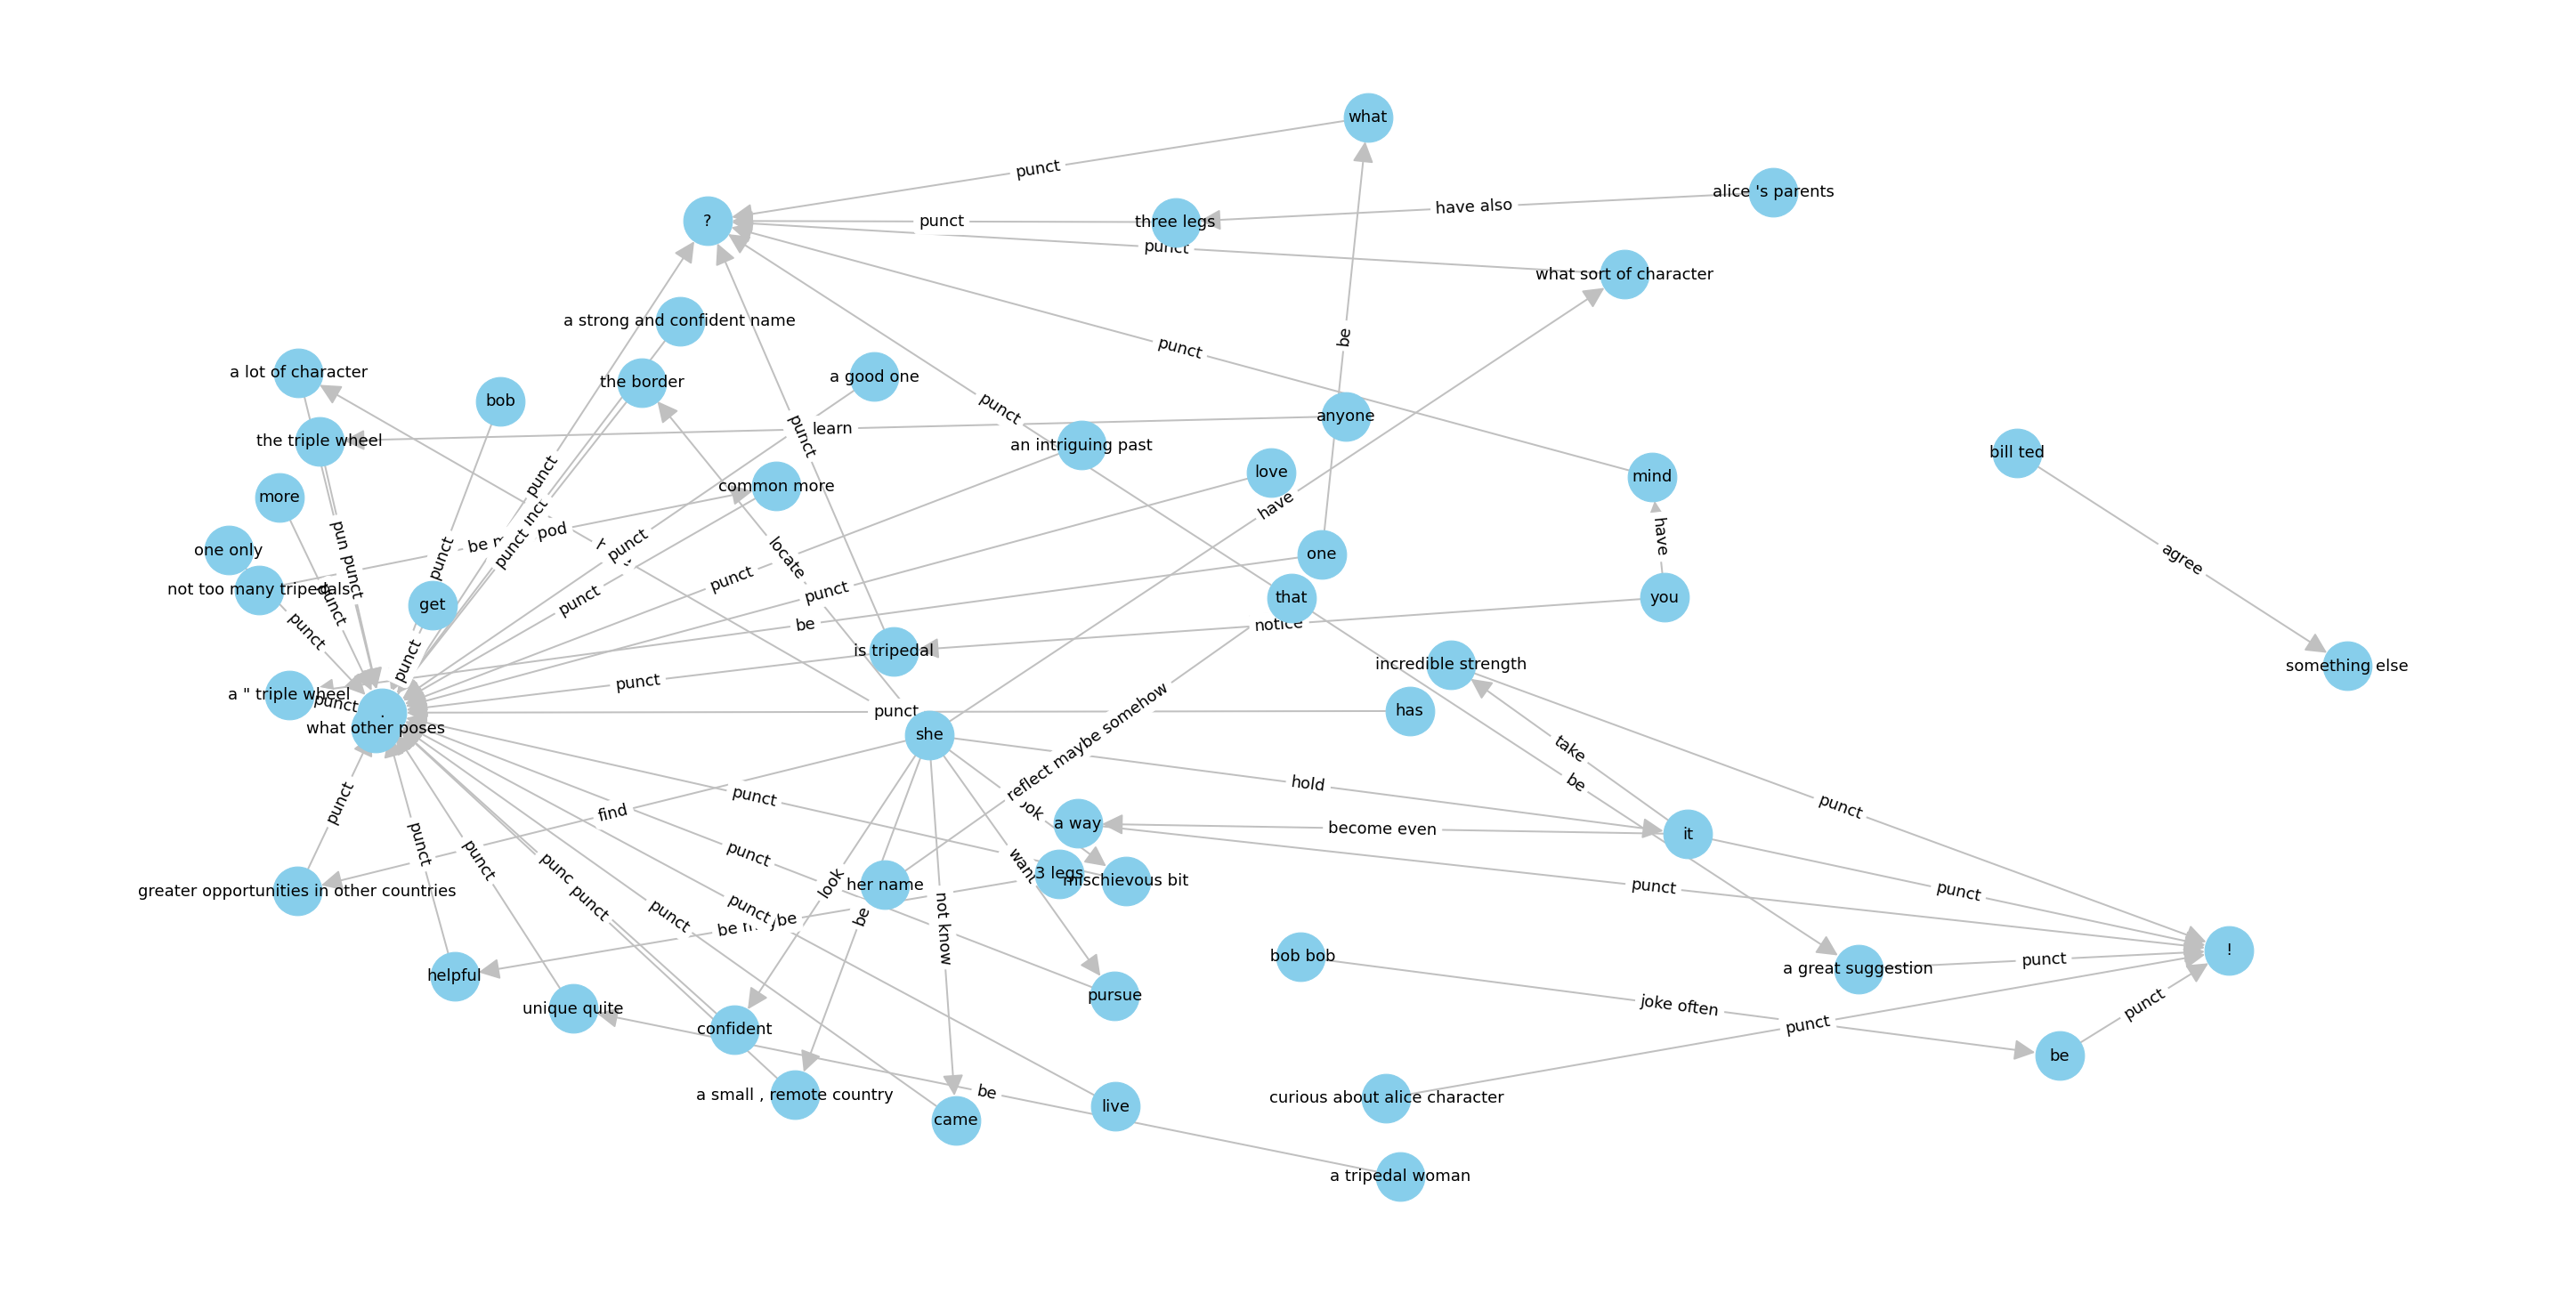

In [32]:
show_fig(G, edge_labels, seed=23)

In [36]:
from relationships import jaccard_similarity, graph_similarity

In [37]:
jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges())

(0.9423076923076923, 0.7922077922077922)

In [38]:
graph_similarity(G, Gpd)

0.8422410922410922

In [41]:
graph_similarity(G, Gpd, edge_bias=0)

0.9423076923076923

In [42]:
graph_similarity(G, Gpd, edge_bias=10)

0.8058532376714195

In [44]:
G = nx.from_edgelist(the_rels)

In [49]:
nx.node_link_data(Gpd)

{'directed': True,
 'multigraph': True,
 'graph': {},
 'nodes': [{'id': 'you'},
  {'id': 'is tripedal'},
  {'id': '?'},
  {'id': 'alice'},
  {'id': '.'},
  {'id': 'she'},
  {'id': 'a lot of character'},
  {'id': 'mind'},
  {'id': 'a good one'},
  {'id': 'a tripedal woman'},
  {'id': 'unique quite'},
  {'id': 'what sort of character'},
  {'id': 'curious about alice character'},
  {'id': '!'},
  {'id': 'confident'},
  {'id': 'mischievous bit'},
  {'id': 'love'},
  {'id': 'more'},
  {'id': 'her name'},
  {'id': 'that'},
  {'id': 'not too many tripedals'},
  {'id': 'common more'},
  {'id': '3 legs'},
  {'id': 'helpful'},
  {'id': 'a great suggestion'},
  {'id': 'a strong and confident name'},
  {'id': 'has'},
  {'id': 'an intriguing past'},
  {'id': 'a small , remote country'},
  {'id': 'the border'},
  {'id': ' bob bob'},
  {'id': 'be'},
  {'id': 'one'},
  {'id': 'what'},
  {'id': 'a " triple wheel'},
  {'id': 'it'},
  {'id': 'incredible strength'},
  {'id': 'anyone'},
  {'id': 'the tripl